## **IDS 561 Big Data Analytics**

### **Movie Recommendation System**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Big Data Project

Mounted at /content/drive
/content/drive/MyDrive/Big Data Project


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -v https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

--2024-04-30 20:00:25--  https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400395283 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.0-bin-hadoop3.tgz’

spark-3.5.0-bin-had 100%[===================>] 381.85M  25.3MB/s    in 16s     

2024-04-30 20:00:41 (24.3 MB/s) - ‘spark-3.5.0-bin-hadoop3.tgz’ saved [400395283/400395283]



In [ ]:
!ls

 Big_Data_Final_Project.ipynb
'Big Data Project.ipynb'
'Copy of Big Data Project.ipynb'
 genome-scores.csv
 genome-tags.csv
 links.csv
 movie-recommendation-system-with-als-in-pyspark.ipynb
'Movie_Recommender_System_IDS_400_Group Project.ipynb'
 movies.csv
 ratings.csv
 README.txt
 spark-3.5.0-bin-hadoop3.tgz
 tags.csv


In [ ]:
!tar -xvf spark-3.5.0-bin-hadoop3.tgz

spark-3.5.0-bin-hadoop3/
spark-3.5.0-bin-hadoop3/kubernetes/
spark-3.5.0-bin-hadoop3/kubernetes/tests/
spark-3.5.0-bin-hadoop3/kubernetes/tests/pyfiles.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/decommissioning.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/autoscale.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/python_executable_check.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/worker_memory_check.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/py_container_checks.py
spark-3.5.0-bin-hadoop3/kubernetes/tests/decommissioning_cleanup.py
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/decom.sh
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/R/
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/R/Dockerfile
spark-3.5.0-bin-hadoop3/kubernetes/dockerfiles/spark/bindings/python/
spark-3.5.0-bin-hadoop3/kubern

In [ ]:
!ls

 Big_Data_Final_Project.ipynb
'Big Data Project.ipynb'
'Copy of Big Data Project.ipynb'
 genome-scores.csv
 genome-tags.csv
 links.csv
 movie-recommendation-system-with-als-in-pyspark.ipynb
'Movie_Recommender_System_IDS_400_Group Project.ipynb'
 movies.csv
 ratings.csv
 README.txt
 spark-3.5.0-bin-hadoop3
 spark-3.5.0-bin-hadoop3.tgz
 tags.csv


In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/MyDrive/Big Data Project/spark-3.5.0-bin-hadoop3"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Spark session has been created successfully.

## **Data Exploration**

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
base_path = "/content/drive/My Drive/Big Data Project/"

movies_df = spark.read.csv(base_path + 'movies.csv', header=True, inferSchema=True)
ratings_df = spark.read.csv(base_path + 'ratings.csv', header=True, inferSchema=True)
tags_df = spark.read.csv(base_path + 'tags.csv', header=True, inferSchema=True)

Data Exploration and Preprocessing

In [ ]:
movies_df.show(5)
# Check for missing values in ratings
ratings_df.describe().show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

+-------+------------------+------------------+------------------+--------------------+
|summary|            userId|           movieId|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|          33832162|          33832162|          33832162|            33832162|
|   mean|165437.98388956048|28313.483493812782|  3.54254040873888|1.2693616767357209E9|
| stddev| 95341.22288520889| 49928.65092773949|1.0639586178664766|2

In [ ]:
# Display the schema and first few rows of each DataFrame
movies_df.printSchema()
movies_df.show(5)

ratings_df.printSchema()
ratings_df.show(5)

tags_df.printSchema()
tags_df.show(5)

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      1|   4.0|1225734739|
|     1|    110|   4.0|1225865086|
|     1|    158|   4.0|1225733503|
|     1|   

In [ ]:
# Summary statistics for ratings
ratings_df.describe().show()

# Count the number of tags per movie
tags_df.groupBy("movieId").count().orderBy("count", ascending=False).show()

+-------+------------------+------------------+------------------+--------------------+
|summary|            userId|           movieId|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|          33832162|          33832162|          33832162|            33832162|
|   mean|165437.98388956048|28313.483493812782|  3.54254040873888|1.2693616767357209E9|
| stddev| 95341.22288520889| 49928.65092773949|1.0639586178664766|2.5410231736548245E8|
|    min|                 1|                 1|               0.5|           789652004|
|    max|            330975|            288983|               5.0|          1689843213|
+-------+------------------+------------------+------------------+--------------------+

+-------+-----+
|movieId|count|
+-------+-----+
|    260|11152|
|  79132| 8978|
|    296| 8753|
|   2571| 7593|
|   2959| 7459|
| 109487| 7331|
|    318| 6839|
|    356| 4880|
|   7361| 4680|
|   4226| 4675|

In [ ]:
# Check for missing values in key columns
for column in ratings_df.columns:
    missing_count = ratings_df.filter(ratings_df[column].isNull()).count()
    if missing_count > 0:
        print(f"Column {column} has {missing_count} missing values.")

# Check for duplicates
print(f"Duplicate entries: {ratings_df.count() - ratings_df.distinct().count()}")

Duplicate entries: 0


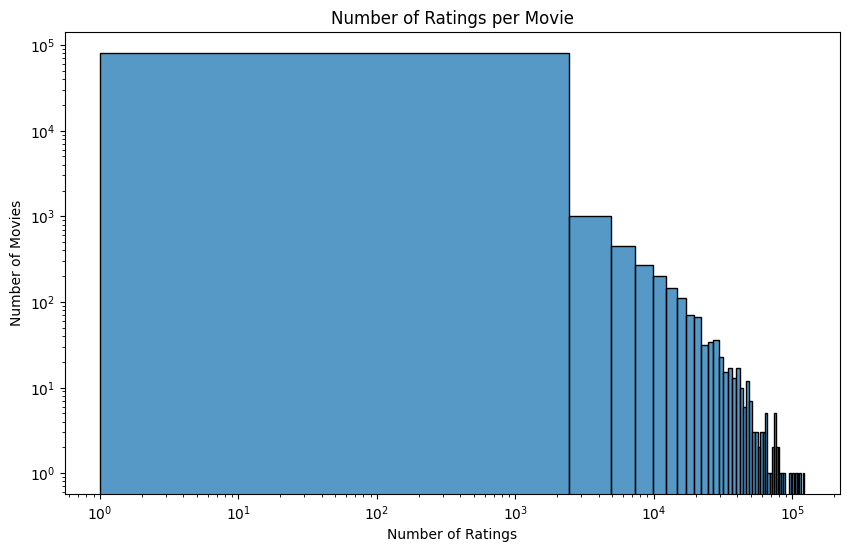

In [ ]:
#Number of ratings per movie
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt

movie_ratings_count = ratings_df.groupBy("movieId").count().orderBy(col("count").desc())

# Convert to pandas for plotting
movie_ratings_count_pandas = movie_ratings_count.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings_count_pandas['count'], bins=50, kde=False)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.xscale('log')
plt.yscale('log')
plt.show()

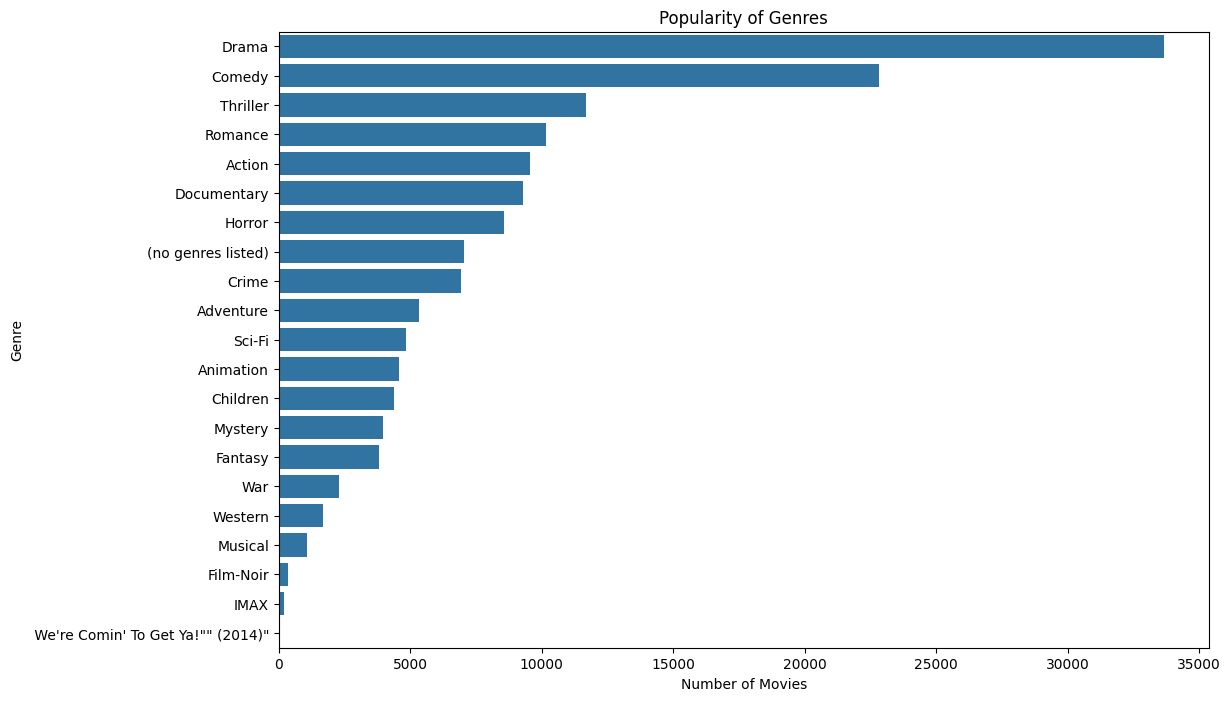

In [ ]:
#Genre Popularity
from pyspark.sql.functions import explode, split

# Split genres into arrays and explode into separate rows
genre_df = movies_df.withColumn("genre", explode(split(col("genres"), "\\|")))

genre_popularity = genre_df.groupBy("genre").count().orderBy("count", ascending=False)

# Convert to pandas for plotting
genre_popularity_pandas = genre_popularity.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='genre', data=genre_popularity_pandas)
plt.title('Popularity of Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

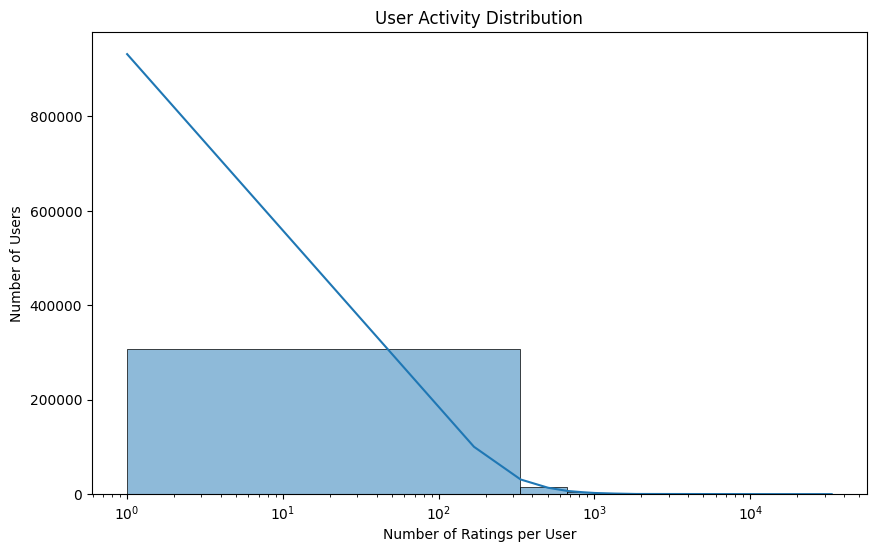

In [ ]:
#User Activity
user_activity = ratings_df.groupBy("userId").count().orderBy("count", ascending=False)

# Convert to pandas for plotting
user_activity_pandas = user_activity.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(user_activity_pandas['count'], bins=100, kde=True)
plt.title('User Activity Distribution')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.xscale('log')
plt.show()

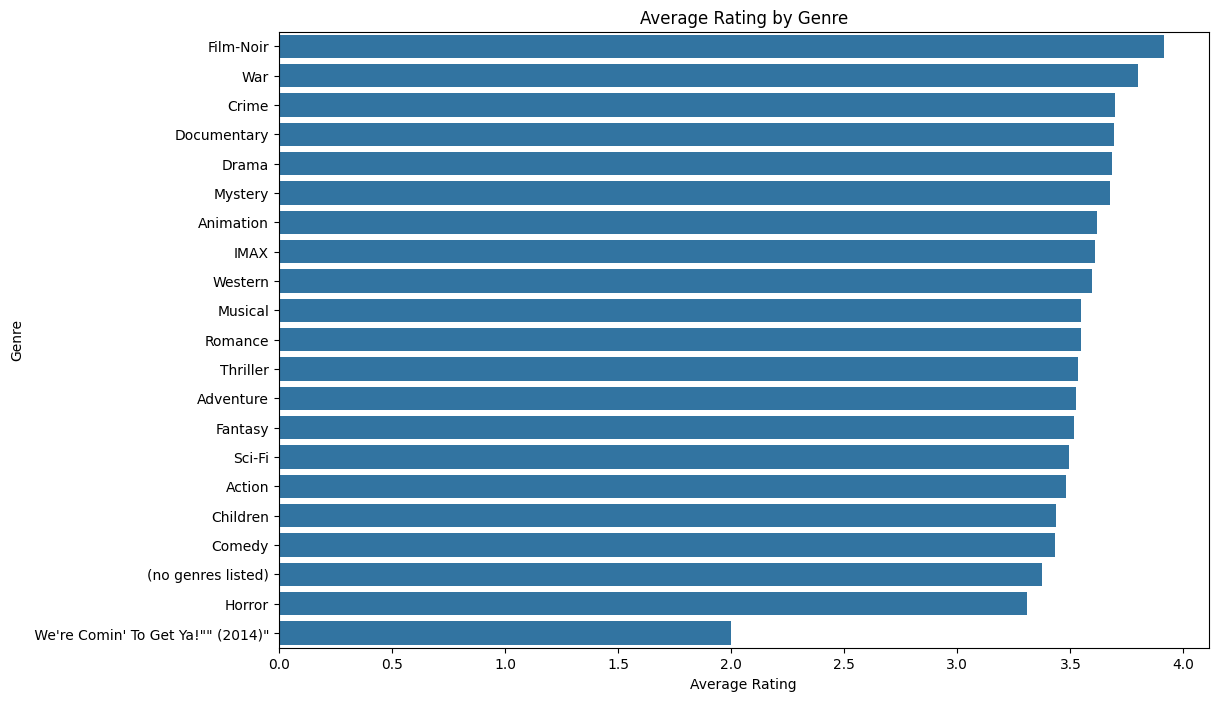

In [ ]:
#Ratings distributed by genre
# Create a new DataFrame by joining movies with ratings
genre_ratings = movies_df.join(ratings_df, "movieId").select("rating", "genres")

# Explode genres for individual genre rating analysis
genre_ratings = genre_ratings.withColumn("genre", explode(split(col("genres"), "\\|")))

# Group by genre and calculate average rating
genre_avg_ratings = genre_ratings.groupBy("genre").avg("rating").orderBy("avg(rating)", ascending=False)

# Convert to pandas for plotting
genre_avg_ratings_pandas = genre_avg_ratings.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x="avg(rating)", y="genre", data=genre_avg_ratings_pandas)
plt.title('Average Rating by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

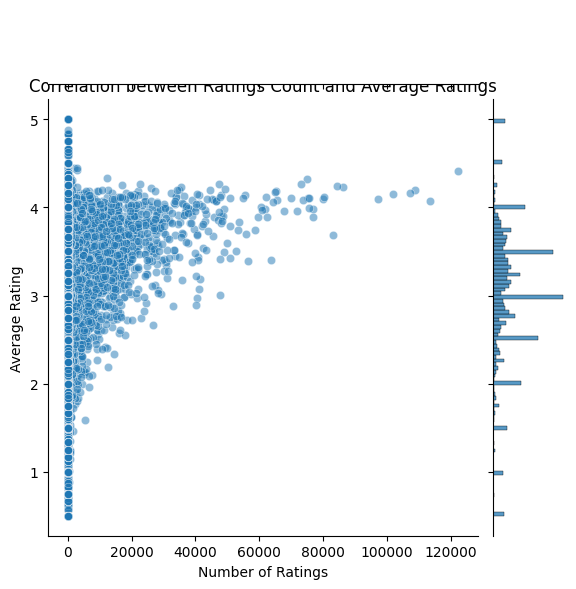

In [ ]:
# Correlation between Ratings Count and Average Ratings
# Compute average rating and count of ratings per movie
from pyspark.sql import functions as F
movie_stats = ratings_df.groupBy("movieId").agg(F.avg("rating").alias("avg_rating"), F.count("rating").alias("rating_count"))

# Convert to pandas for scatter plot
movie_stats_pandas = movie_stats.toPandas()

sns.jointplot(x='rating_count', y='avg_rating', data=movie_stats_pandas, kind='scatter', alpha=0.5)
plt.title('Correlation between Ratings Count and Average Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

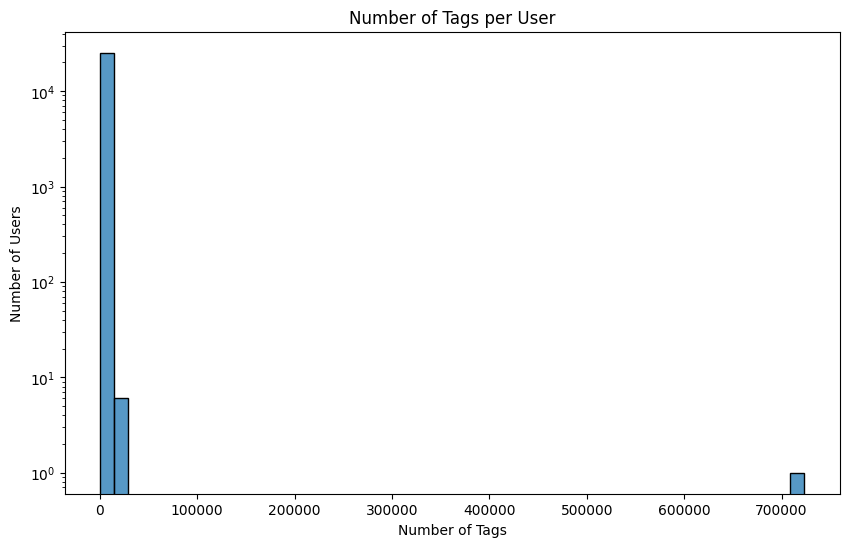

In [ ]:
#Distribution of tags per user
# Count tags by user
tags_per_user = tags_df.groupBy("userId").count().orderBy("count", ascending=False)

# Convert to pandas for plotting
tags_per_user_pandas = tags_per_user.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(tags_per_user_pandas['count'], bins=50, kde=False)
plt.title('Number of Tags per User')
plt.xlabel('Number of Tags')
plt.ylabel('Number of Users')
plt.yscale('log')
plt.show()

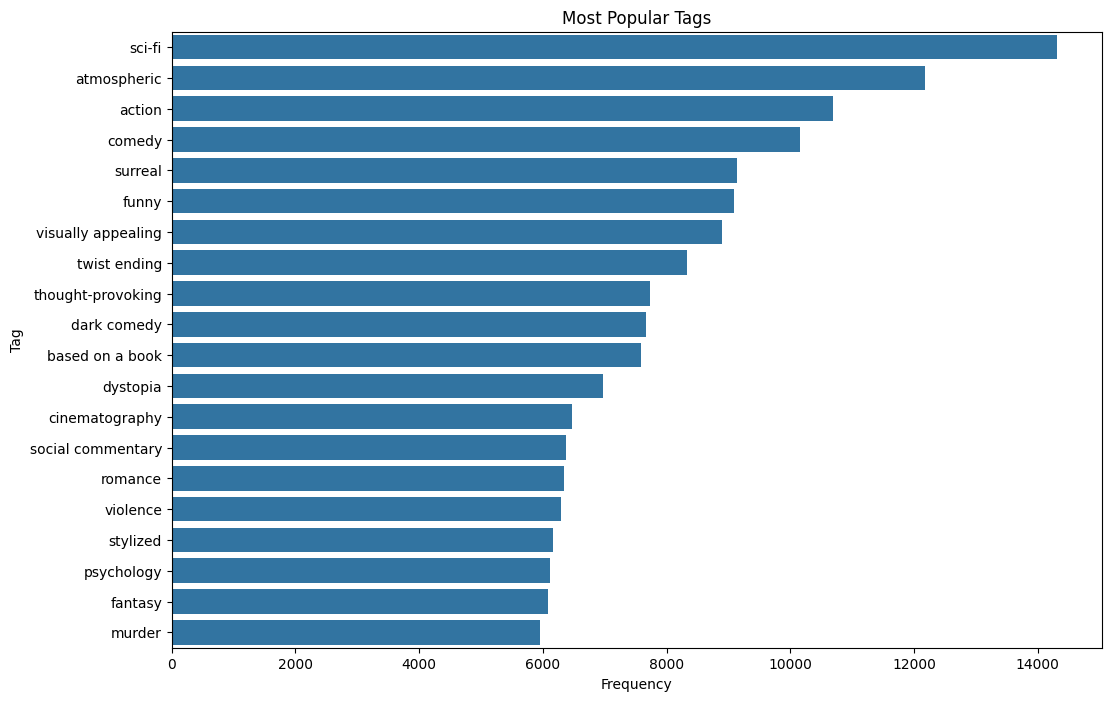

In [ ]:
#Popular Tags Analysis
# Count the frequency of each tag
tag_frequency = tags_df.groupBy("tag").count().orderBy("count", ascending=False).limit(20)

# Convert to pandas for plotting
tag_frequency_pandas = tag_frequency.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='tag', data=tag_frequency_pandas)
plt.title('Most Popular Tags')
plt.xlabel('Frequency')
plt.ylabel('Tag')
plt.show()

## **MODEL Building**

### **ALS Model**

Hyperparameter tuning to find the best hyperparameters.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession

# Splitting the data
(training, test) = ratings_df.randomSplit([0.7, 0.3])

# Define a list of parameters to test
ranks = [50]
maxIters = [5, 10]
regParams = [0.01]

# Setting up the evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Placeholder for storing the best model and its parameters
best_rmse = float('inf')
best_params = {}
best_model = None

# Loop through all the parameters
for rank in ranks:
    for maxIter in maxIters:
        for regParam in regParams:
            # Configure ALS model with the current set of parameters
            als = ALS(maxIter=maxIter, rank=rank, regParam=regParam,
                      userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

            # Fit the ALS model
            model = als.fit(training)

            # Make predictions
            predictions = model.transform(test)

            # Evaluate the model
            rmse = evaluator.evaluate(predictions)

            # Print the performance of the current model
            print(f"Rank: {rank}, maxIter: {maxIter}, regParam: {regParam}, RMSE: {rmse}")

            # Update the best model if the current one is better
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {'rank': rank, 'maxIter': maxIter, 'regParam': regParam}
                best_model = model

# Output the best parameters and RMSE
print(f"Best parameters: Rank = {best_params['rank']}, MaxIter = {best_params['maxIter']}, RegParam = {best_params['regParam']}")
print(f"Best RMSE: {best_rmse}")

Rank: 50, maxIter: 5, regParam: 0.01, RMSE: 0.8674588783203713
Rank: 50, maxIter: 10, regParam: 0.01, RMSE: 0.8761881351717622
Best parameters: Rank = 50, MaxIter = 5, RegParam = 0.01
Best RMSE: 0.8674588783203713


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession

# Splitting the data
(training, test) = ratings_df.randomSplit([0.7, 0.3])

# Define a list of parameters to test
ranks = [8, 12, 15]
maxIters = [5, 10]
regParams = [0.05]

# Setting up the evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Placeholder for storing the best model and its parameters
best_rmse = float('inf')
best_params = {}
best_model = None

# Loop through all the parameters
for rank in ranks:
    for maxIter in maxIters:
        for regParam in regParams:
            # Configure ALS model with the current set of parameters
            als = ALS(maxIter=maxIter, rank=rank, regParam=regParam,
                      userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

            # Fit the ALS model
            model = als.fit(training)

            # Make predictions
            predictions = model.transform(test)

            # Evaluate the model
            rmse = evaluator.evaluate(predictions)

            # Print the performance of the current model
            print(f"Rank: {rank}, maxIter: {maxIter}, regParam: {regParam}, RMSE: {rmse}")

            # Update the best model if the current one is better
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {'rank': rank, 'maxIter': maxIter, 'regParam': regParam}
                best_model = model

# Output the best parameters and RMSE
print(f"Best parameters: Rank = {best_params['rank']}, MaxIter = {best_params['maxIter']}, RegParam = {best_params['regParam']}")
print(f"Best RMSE: {best_rmse}")

Rank: 8, maxIter: 5, regParam: 0.05, RMSE: 0.8192743197088713
Rank: 8, maxIter: 5, regParam: 0.1, RMSE: 0.8172402254562403
Rank: 8, maxIter: 10, regParam: 0.05, RMSE: 0.8077232948646322
Rank: 8, maxIter: 10, regParam: 0.1, RMSE: 0.8118731044226436
Rank: 12, maxIter: 5, regParam: 0.05, RMSE: 0.8105654302285517
Rank: 12, maxIter: 5, regParam: 0.1, RMSE: 0.8113113023681285
Rank: 12, maxIter: 10, regParam: 0.05, RMSE: 0.7990899398075423
Rank: 12, maxIter: 10, regParam: 0.1, RMSE: 0.8070697363931431
Best parameters: Rank = 12, MaxIter = 10, RegParam = 0.05
Best RMSE: 0.7990899398075423


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import IntegerType

# Split the data into training and test sets for evaluation
(training_data, test_data) = ratings_df.randomSplit([0.7, 0.3])

# Setting up ALS model with the best parameters found
als_best = ALS(
    maxIter=best_params['maxIter'],
    rank=best_params['rank'],
    regParam=best_params['regParam'],
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"
)

# Fitting the best model on the training data
final_model = als_best.fit(training_data)

# Making predictions on the test data
predictions = final_model.transform(test_data)

# Setting up the evaluator for measuring the RMSE
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

# Evaluating the model
rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)

# Print RMSE and MAE
print(f"Root-mean-square error = {rmse}")
print(f"Mean Absolute Error = {mae}")

Root-mean-square error = 0.7975283625374993
Mean Absolute Error = 0.6080287468270604


In [ ]:
# Define a threshold above which ratings are considered positive
threshold = 3.5

# Creating binary labels for actual and predicted ratings
predictions = predictions.withColumn('actual', (col('rating') >= threshold).cast("int"))
predictions = predictions.withColumn('predicted', (col('prediction') >= threshold).cast("int"))

# Calculating metrics
TP = predictions.filter("predicted == 1 AND actual == 1").count()
FP = predictions.filter("predicted == 1 AND actual == 0").count()
FN = predictions.filter("predicted == 0 AND actual == 1").count()

# Precision and recall
precision = TP / (TP + FP) if TP + FP != 0 else 0
recall = TP / (TP + FN) if TP + FN != 0 else 0

print(f"Precision = {precision}")
print(f"Recall = {recall}")

Precision = 0.8592540880092846
Recall = 0.6947426129271025


In [ ]:
confusion_data = predictions.select('actual', 'predicted')

# Counting occurrences for confusion matrix
confusion_matrix = confusion_data.groupby('actual', 'predicted').count().toPandas()

# Matrix format
confusion_matrix_pivot = confusion_matrix.pivot(index='actual', columns='predicted', values='count').fillna(0)

print(confusion_matrix_pivot)

predicted        0        1
actual                     
0          2998987   729214
1          1956064  4451853


In [ ]:
from pyspark.sql.functions import col, when, rand, expr

# Selecting 5 random users from the test data
random_users = test_data.select("userId").distinct().orderBy(rand()).limit(5)

# Top 10 movie recommendations for these users
user_recommendations = final_model.recommendForUserSubset(random_users, 10)

# Displaying the recommendations for each user
user_recommendations.show(truncate=False)

# Showing recommendations in a more readable format:
user_recommendations.select("userId", expr("explode(recommendations) as recommendation")).select(
    "userId",
    "recommendation.*"
).show(truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                                |
+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|317491|[{162436, 7.2877355}, {136882, 6.7270675}, {176657, 6.343243}, {205453, 6.087596}, {256477, 5.9144373}, {151989, 5.9011445}, {216077, 5.870509}, {270306, 5.8675847}, {240070, 5.8675847}, {240054, 5.8675847}]|
|72293 |[{205453, 5.6558757}, {214036, 5.610165}, {131550, 5.2897453}, {84983, 5.251011}, {216663, 5.2039537}, {122772, 5.202089}, {

## **User Based Collaborative Filtering**

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.evaluation import RegressionEvaluator

# Assume ratings_df is already loaded
(training_data, test_data) = ratings_df.randomSplit([0.7, 0.3])

# Setting up ALS model for user-based collaborative filtering
als_user_based = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    implicitPrefs=False,
    rank=10,
    maxIter=10,
    regParam=0.1
)

# Fitting the model on the training data
model_user_based = als_user_based.fit(training_data)

# Making predictions on the test data
predictions_user_based = model_user_based.transform(test_data)

# Evaluate the model with RMSE and MAE
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

rmse_user_based = rmse_evaluator.evaluate(predictions_user_based)
mae_user_based = mae_evaluator.evaluate(predictions_user_based)

print(f"Root-mean-square error (User-Based CF) = {rmse_user_based}")
print(f"Mean Absolute Error (User-Based CF) = {mae_user_based}")

# Generate top 10 recommendations for all users
user_recs = model_user_based.recommendForAllUsers(10)

# Define a relevance threshold and prepare data for precision and recall calculation
relevance_threshold = 3.5
relevant_test_data = test_data.filter(F.col("rating") >= relevance_threshold)

# Flatten recommendations and join with relevant test data
flat_recs = user_recs.withColumn("recommendation", F.explode("recommendations")).select("userId", "recommendation.movieId")

# Check if recommended items are relevant
is_relevant = flat_recs.join(relevant_test_data, (flat_recs.userId == relevant_test_data.userId) & (flat_recs.movieId == relevant_test_data.movieId), 'left_outer').withColumn("is_relevant", F.when(F.col("rating") >= relevance_threshold, 1).otherwise(0))

# Calculate overall precision and recall
total_relevant = relevant_test_data.count()
total_recommended = flat_recs.count()
total_true_positives = is_relevant.filter("is_relevant = 1").count()

overall_precision = total_true_positives / total_recommended if total_recommended else 0
overall_recall = total_true_positives / total_relevant if total_relevant else 0

print(f"Overall Precision: {overall_precision}\nOverall Recall: {overall_recall}")


Root-mean-square error (User-Based CF) = 0.8084182460271822
Mean Absolute Error (User-Based CF) = 0.6208979441101384
Overall Precision: 2.1358133177113843e-06
Overall Recall: 1.0911780592151156e-06
